# Bivariate Analysis

In [1]:
import pandas as pd
from sklearn.compose import make_column_selector as selector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency


In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.drop(['id'], axis=1, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# df['bmi_missing'] = df['bmi']
# pd.crosstab(df['bmi_missing'], df['stroke'], normalize='index')
# bmi_median = df["bmi"].median()
# df["bmi"] = df["bmi"].fillna(bmi_median)

### sort out column types

In [4]:

# Automatically select columns
numerical_selector = selector(dtype_include=['int64', 'float64'])
categorical_selector = selector(dtype_include=['object', 'category', 'bool'])

# Get initial lists
numerical_cols = numerical_selector(df)
categorical_cols = categorical_selector(df)

# Identify binary numeric columns (with only two unique values)
binary_numerical_cols = [col for col in numerical_cols 
                         if df[col].nunique(dropna=False) == 2]

# Move them from numerical to categorical
numerical_cols = [col for col in numerical_cols if col not in binary_numerical_cols]
categorical_cols = categorical_cols + binary_numerical_cols

# Results
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['age', 'avg_glucose_level', 'bmi']
Categorical columns: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease', 'stroke']


## Numerical Data Univariate analysis

### Descriptive statistics

In [5]:
# First, compute .describe() separately for each stroke group

desc_all = df[numerical_cols].describe()
desc_0 = df[df['stroke'] == 0][numerical_cols].describe()
desc_1 = df[df['stroke'] == 1][numerical_cols].describe()

# Rename columns to include stroke group
desc_all = desc_all.add_suffix('_all')
desc_0 = desc_0.add_suffix('_0')
desc_1 = desc_1.add_suffix('_1')

# Combine side-by-side on index (statistic)
final_df = pd.concat([desc_all,desc_0, desc_1], axis=1)

final_df = final_df.reset_index().rename(columns={'index': 'stat'})

In [6]:
final_df[sorted(final_df.columns)].set_index('stat')

,age_0,age_1,age_all,avg_glucose_level_0,avg_glucose_level_1,avg_glucose_level_all,bmi_0,bmi_1,bmi_all
stat,,,,,,,,,
count,4861.000000,249.000000,5110.000000,4861.000000,249.000000,5110.000000,4700.000000,209.000000,4909.000000
mean,41.971545,67.728193,43.226614,104.795513,132.544739,106.147677,28.823064,30.471292,28.893237
std,22.291940,12.727419,22.612647,43.846069,61.921056,45.283560,7.908287,6.329452,7.854067
min,0.080000,1.320000,0.080000,55.120000,56.110000,55.120000,10.300000,16.900000,10.300000
25%,24.000000,59.000000,25.000000,77.120000,79.790000,77.245000,23.400000,26.400000,23.500000
50%,43.000000,71.000000,45.000000,91.470000,105.220000,91.885000,28.000000,29.700000,28.100000
75%,59.000000,78.000000,61.000000,112.830000,196.710000,114.090000,33.100000,33.700000,33.100000
max,82.000000,82.000000,82.000000,267.760000,271.740000,271.740000,97.600000,56.600000,97.600000


### Numerical columns distribution

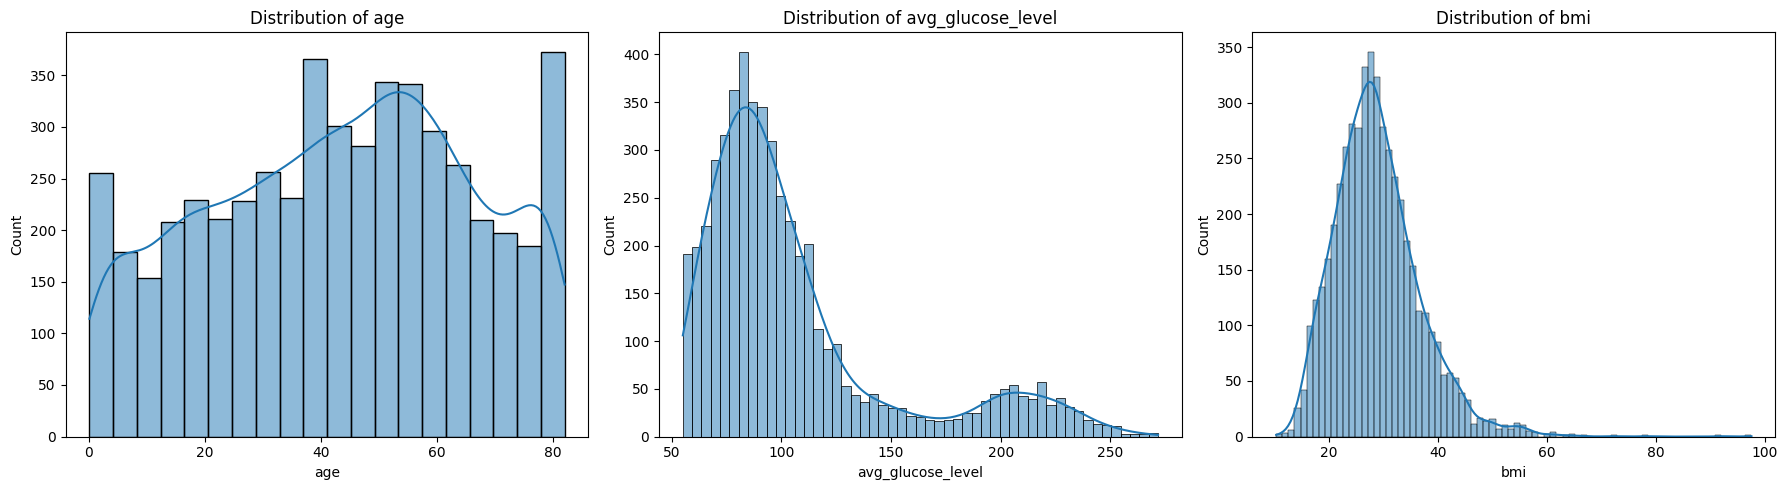

In [7]:
total = len(numerical_cols)
cols = 3
plt.figure(figsize=(18, 5 * ((total + cols - 1) // cols)))
for i, col in enumerate(numerical_cols):
    plt.subplot((total + cols - 1) // cols, cols, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

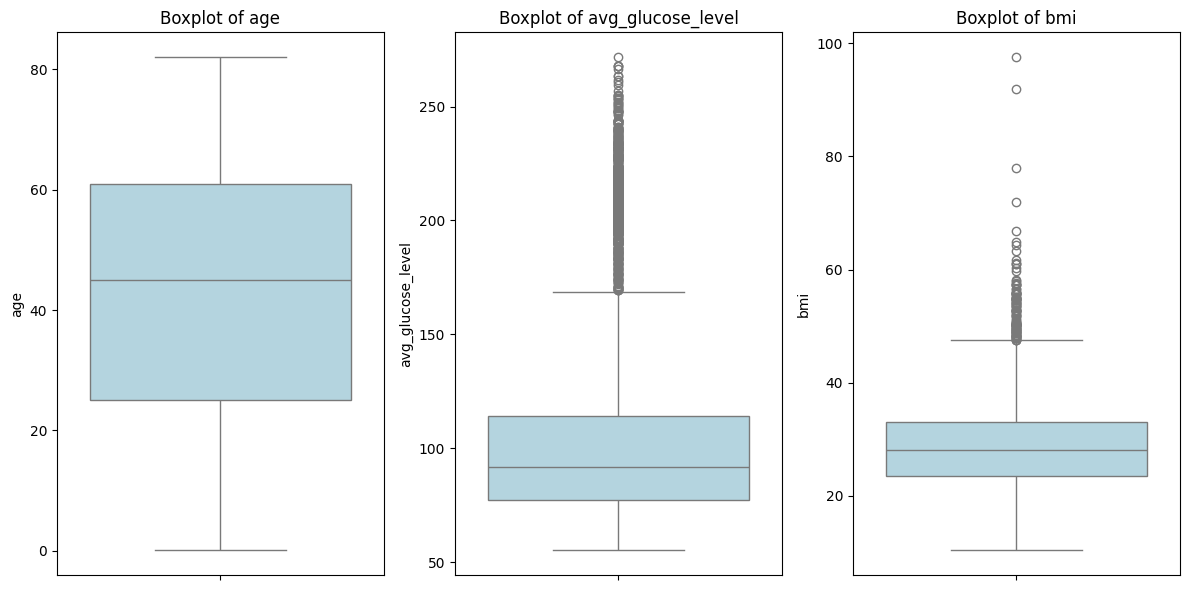

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns
num_cols = ['age', 'avg_glucose_level', 'bmi']

# Plot boxplots for each column
plt.figure(figsize=(12, 6))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    
plt.show()


np.int64(3)

### Normality Test (QQ plot)

### Skewness and kurtosis

## 2. categorical data Univariate analysis

### Frequency count

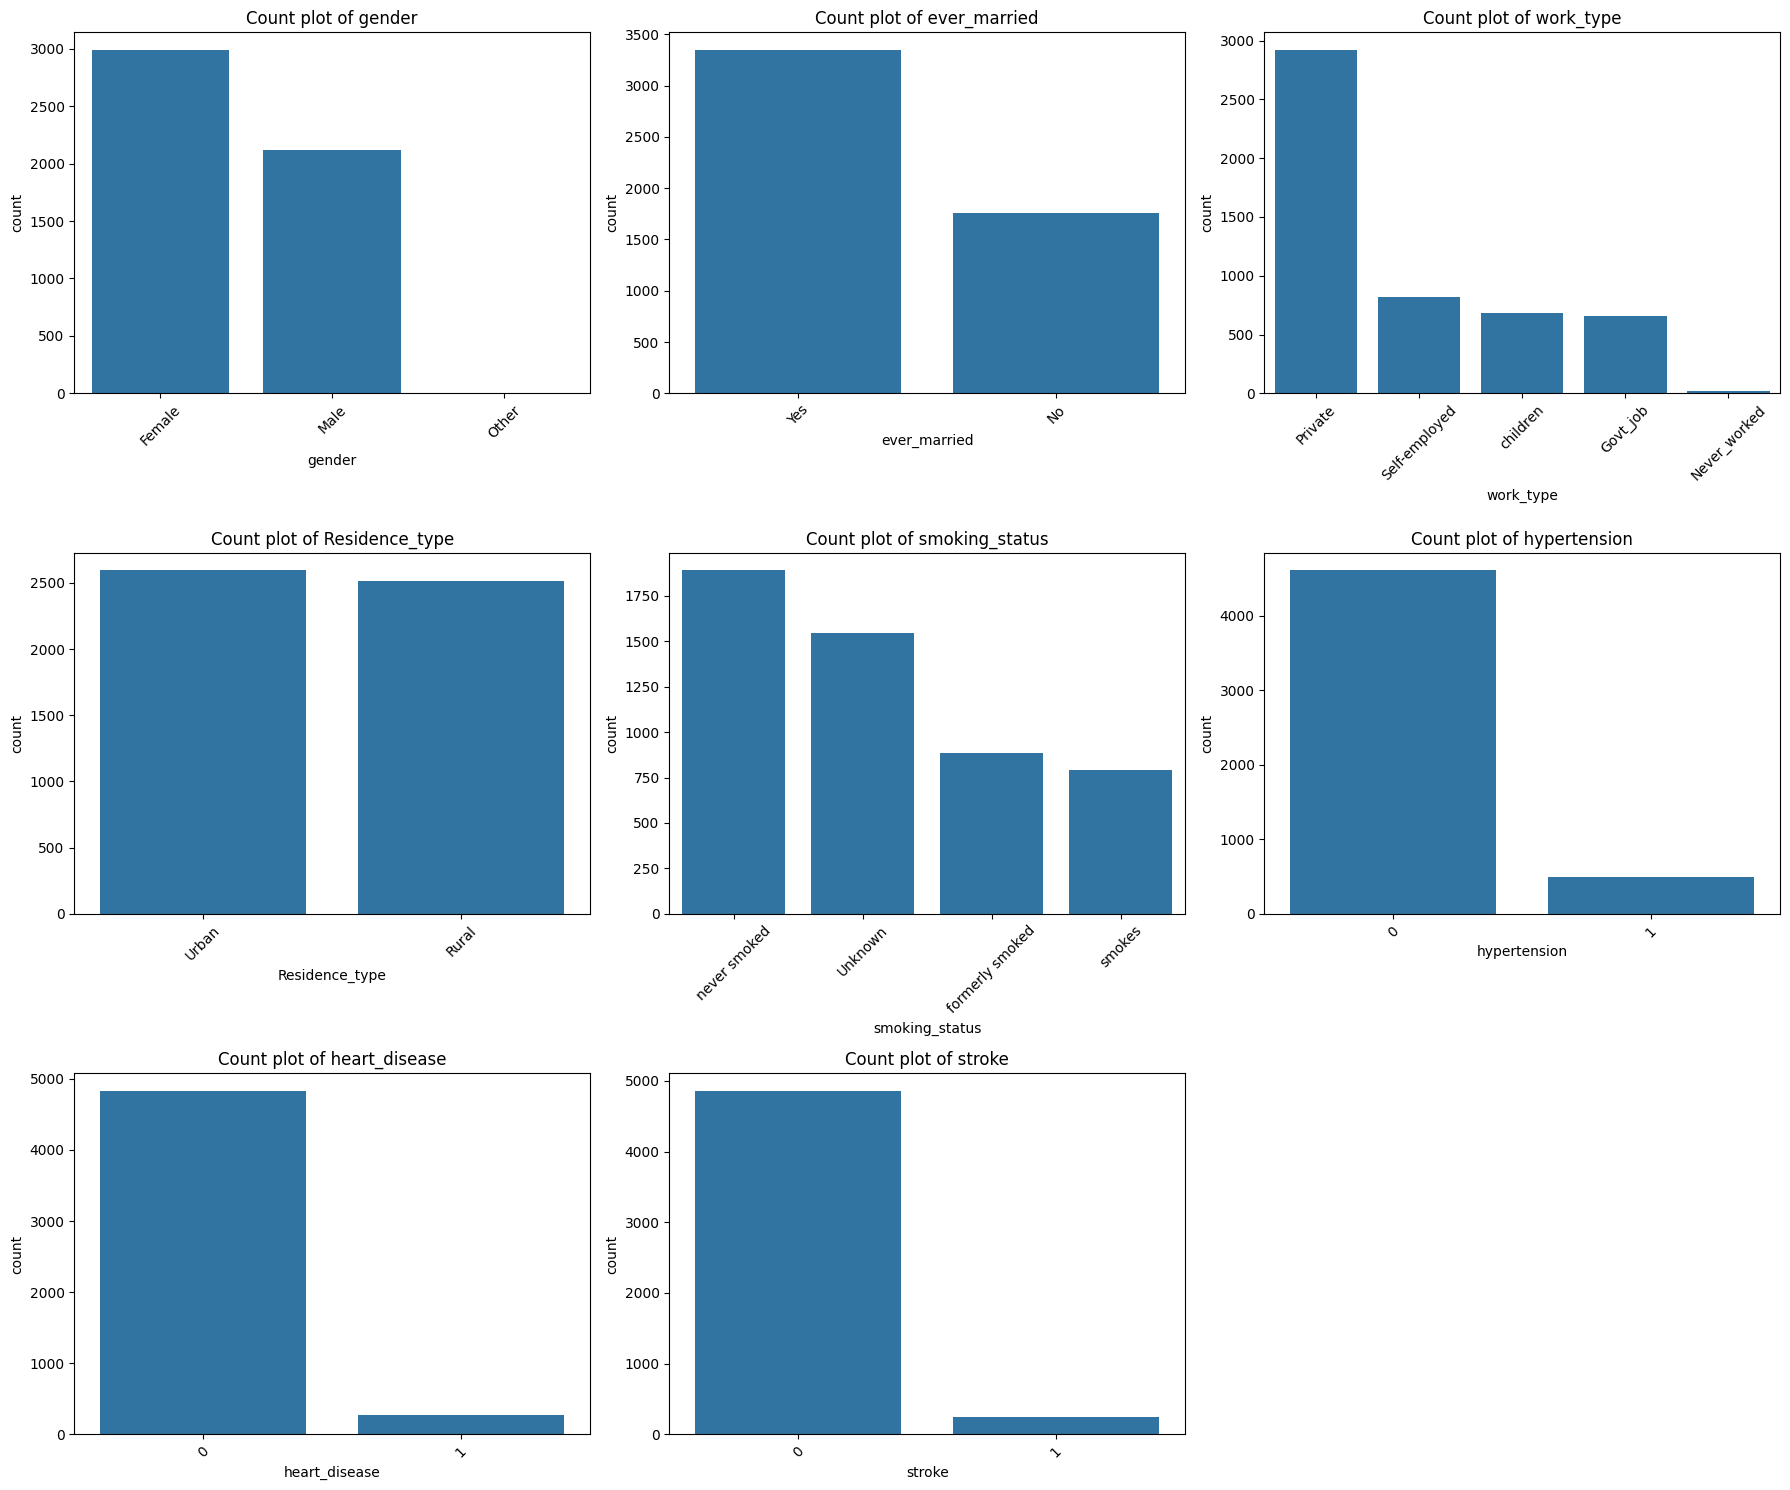

In [8]:
# cols = 3  # Number of columns per row
total = len(categorical_cols)

plt.figure(figsize=(18, 5 * ((total + 3 - 1) // cols)))

for i, col in enumerate(categorical_cols):
    plt.subplot((total + cols - 1) // cols, cols, i + 1)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 3. Bivariate analysis

### Median comparision

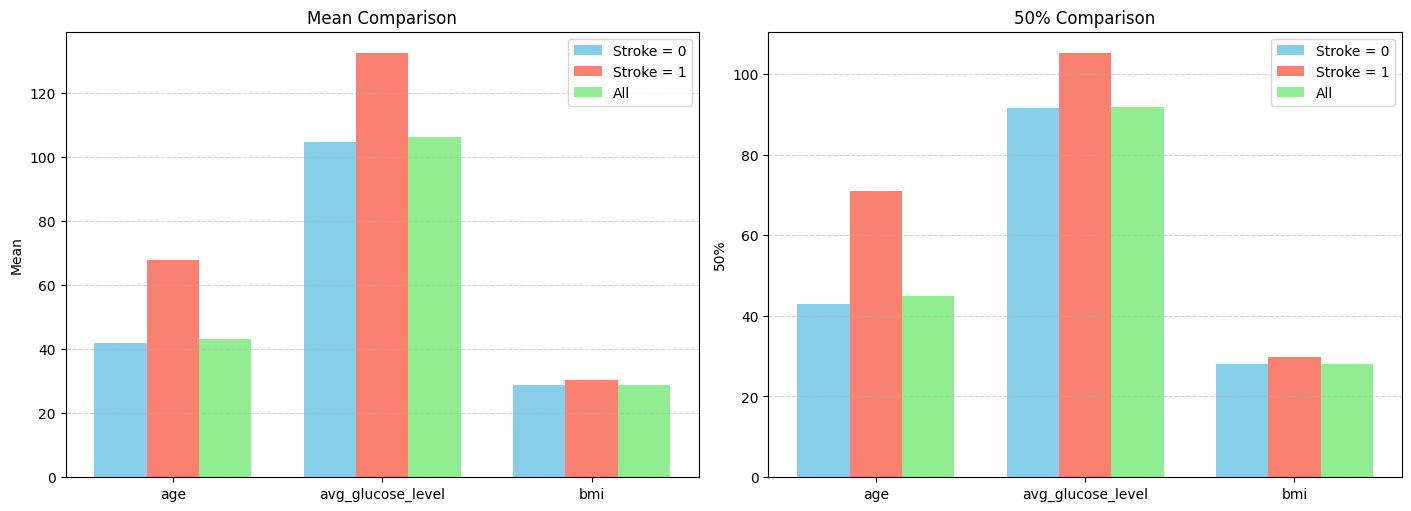

In [9]:
import matplotlib.pyplot as plt

final_df = final_df.set_index('stat')
stats_to_plot = ['mean', '50%']
features = ['age', 'avg_glucose_level', 'bmi']
width = 0.25
x = range(len(features))

fig, axs = plt.subplots(1, len(stats_to_plot), figsize=(14, 5), constrained_layout=True)

for i, stat in enumerate(stats_to_plot):
    cols_0 = [f'{feat}_0' for feat in features]
    cols_1 = [f'{feat}_1' for feat in features]
    cols_all = [f'{feat}_all' for feat in features]

    vals_0 = final_df.loc[stat, cols_0]
    vals_1 = final_df.loc[stat, cols_1]
    vals_all = final_df.loc[stat, cols_all]

    ax = axs[i]
    ax.bar([p - width for p in x], vals_0, width, label='Stroke = 0', color='skyblue')
    ax.bar(x, vals_1, width, label='Stroke = 1', color='salmon')
    ax.bar([p + width for p in x], vals_all, width, label='All', color='lightgreen')

    ax.set_xticks(x)
    ax.set_xticklabels(features)
    ax.set_ylabel(stat.capitalize())
    ax.set_title(f'{stat.capitalize()} Comparison')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


<b>Further analysis:</b>
<pre><b>Lead:</b>
There is higher possibility if person is older and higher glucose level that the person got stroke. However there is tiny difference
in medians of bmi who got stroke and no stroke. SO lets us check this using statistics.

    H0 : There is no difference in medians of bmi while stroke =0 and stroke =1
    H1: There is difference in medians

    Considerations: Since the data is not normally distributed, we use non parametric methods i.e Manwitney test
    

### scatter plots of numerical variables

<Axes: xlabel='avg_glucose_level', ylabel='bmi'>

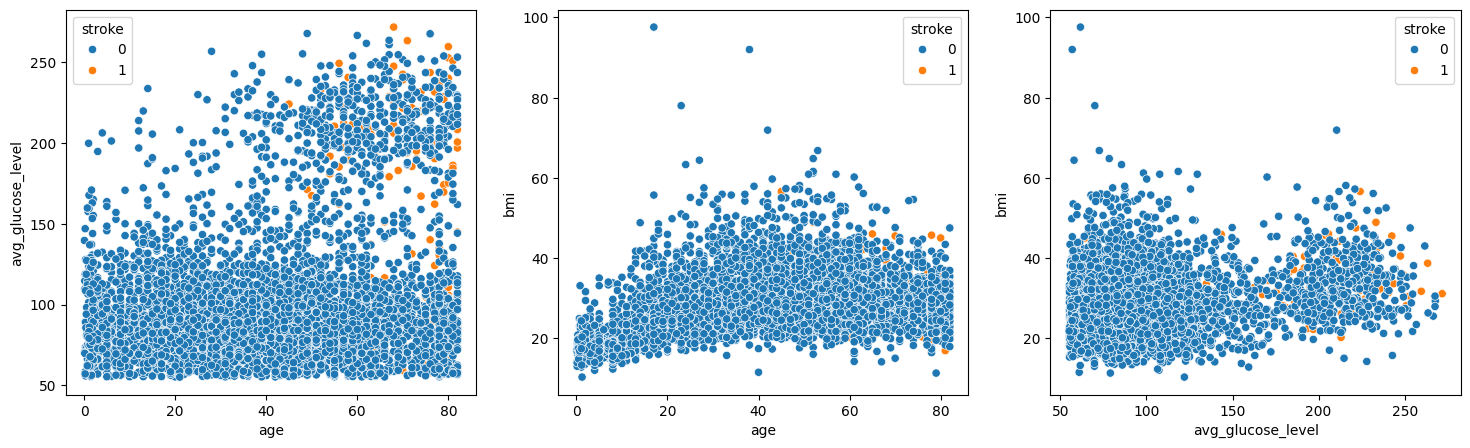

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(6 * 3, 5 * 1))
   
sns.scatterplot(x='age', y='avg_glucose_level', ax = axes[0], hue='stroke', data=df)
sns.scatterplot(x='age', y='bmi',  ax = axes[1], hue='stroke', data=df)
sns.scatterplot(x='avg_glucose_level', y='bmi',  ax = axes[2], hue='stroke', data=df)


### Categorical columns Bivariate

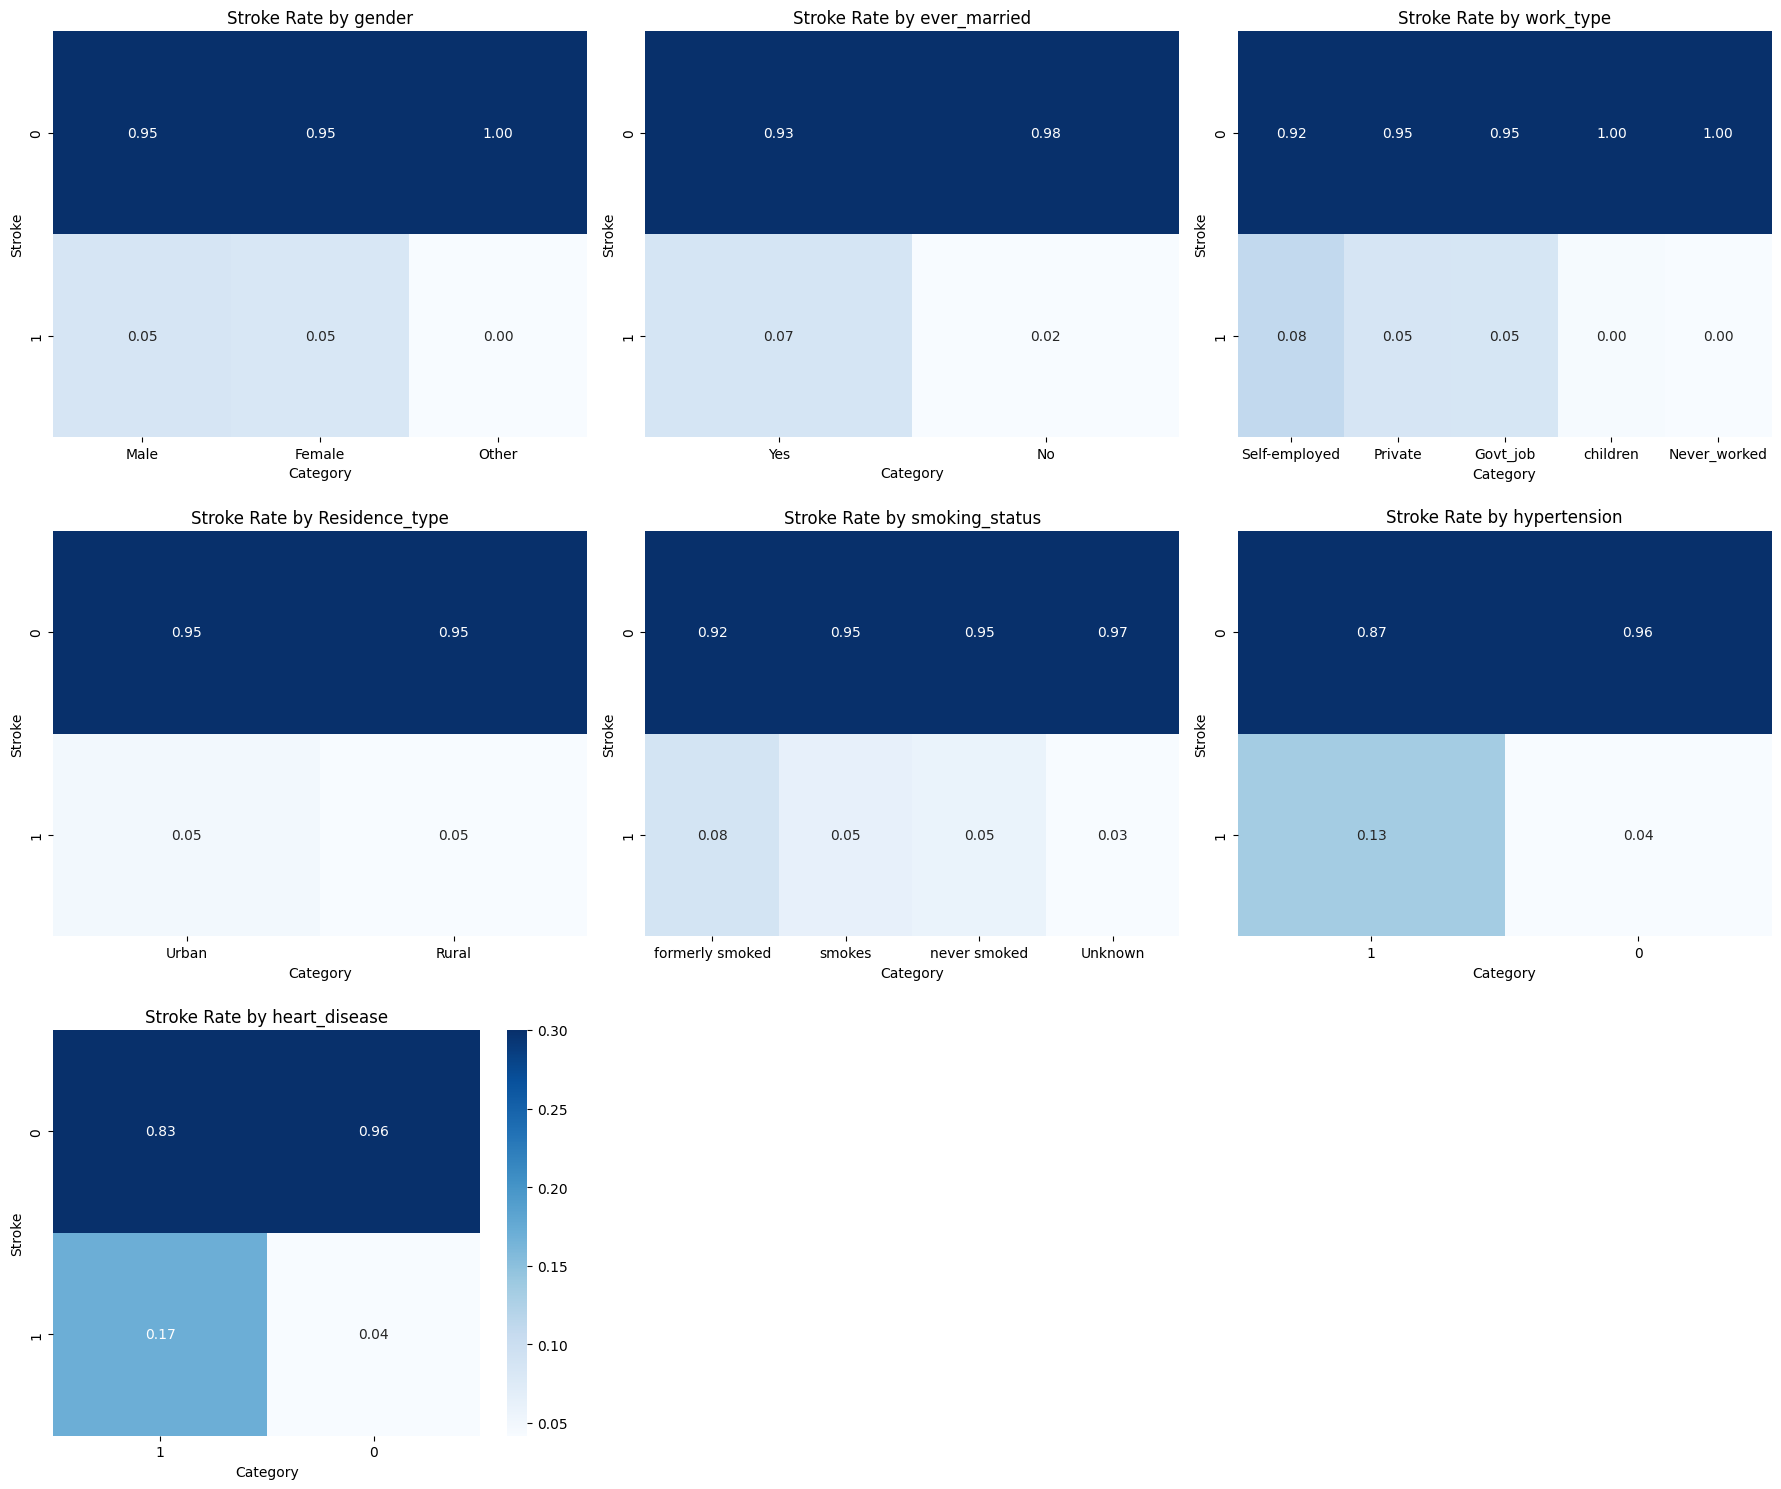

In [30]:

# Exclude target
filtered_cats = categorical_cols.copy()
filtered_cats.remove('stroke')

cols = 3
total = len(filtered_cats)
rows = (total + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(filtered_cats):
    # Calculate stroke rate per category
    ct = pd.crosstab(df[col], df['stroke'], normalize='index')  # stroke=0 and stroke=1 as columns

    # Sort by stroke rate (stroke=1)
    if 1 in ct.columns:
        ct = ct.sort_values(by=1, ascending=False)

    # Transpose to put stroke on y-axis (optional)
    ct_plot = ct.T  # shape: [stroke=0, stroke=1] x categories

    # Plot heatmap
    sns.heatmap(ct_plot, annot=True, cmap='Blues', vmax=0.3, fmt='.2f', ax=axes[i], 
                cbar=i == total - 1)

    axes[i].set_title(f'Stroke Rate by {col}')
    axes[i].set_xlabel('Category')
    axes[i].set_ylabel('Stroke')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(h_pad=2)
plt.show()


In [ ]:
### 

### Is the higher stroke rate among self-employed due to their higher age/glucose levels?

In [7]:
df_self_emp_stroke = df[(df['work_type'] == 'Self-employed') & (df['stroke'] == 1)]
df_self_emp_no_stroke = df[(df['work_type'] == 'Self-employed') & (df['stroke'] == 0)]

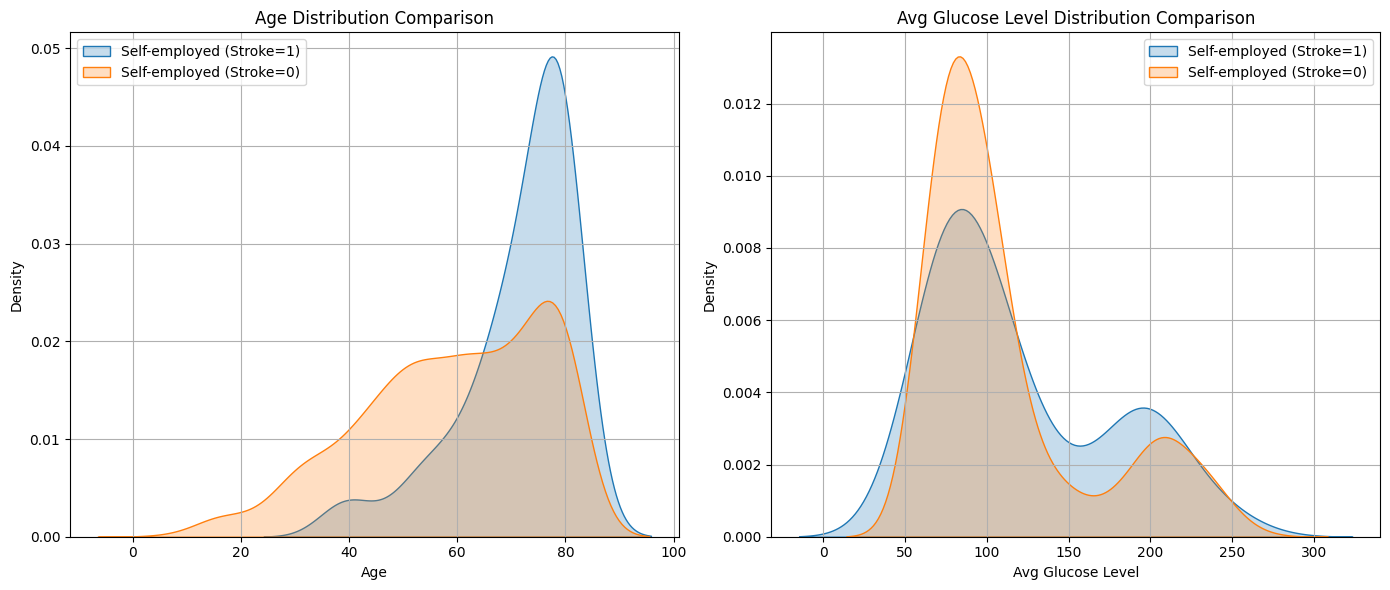

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, feature, title in zip(
    axes,
    ['age', 'avg_glucose_level'],
    ['Age Distribution Comparison', 'Avg Glucose Level Distribution Comparison'],
):
    sns.kdeplot(
        df_self_emp_stroke[feature], label='Self-employed (Stroke=1)', fill=True, ax=ax
    )
    sns.kdeplot(
        df_self_emp_no_stroke[feature], label='Self-employed (Stroke=0)', fill=True, ax=ax
    )
    ax.set(title=title, xlabel=feature.replace('_', ' ').title(), ylabel='Density')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [9]:
for feature in ['age', 'avg_glucose_level']:
    u_stat, p_val = mannwhitneyu(
        df_self_emp_stroke[feature], 
        df_self_emp_no_stroke[feature], 
        alternative='two-sided'
    )
    print(f"{feature}: u_stat={u_stat:.4f}, p_val={p_val:.4f}")

age: u_stat=35029.0000, p_val=0.0000
avg_glucose_level: u_stat=26125.0000, p_val=0.3762


<pre><b>Insights:</b>
    1. The age distribution for self-employed individuals who suffered a stroke is significantly right-shifted compared to 
    those who didn’t. This suggests that the elevated stroke proportion in the self-employed category may be partially 
    explained by their older average age.
    
    2. Among self-employed individuals, those who experienced a stroke exhibited a higher average glucose level distribution,
    with a distinct secondary mode above 200 mg/dL. This contrasts with the non-stroke group, which was concentrated in the 
    normoglycemic range (~90 mg/dL), indicating that elevated glucose may be a significant risk factor in this subgroup.

    3. Although self-employed stroke cases showed a modest shift in glucose levels, only age demonstrated a statistically 
    significant difference. Therefore, the elevated stroke rate in self-employed individuals appears primarily attributable to 
    their older age profile.
    
</pre>

In [10]:
df_ht_stroke = df[(df['heart_disease'] == 1) & (df['stroke'] == 1)]
df_ht_no_stroke = df[(df['heart_disease'] == 1) & (df['stroke'] == 0)]

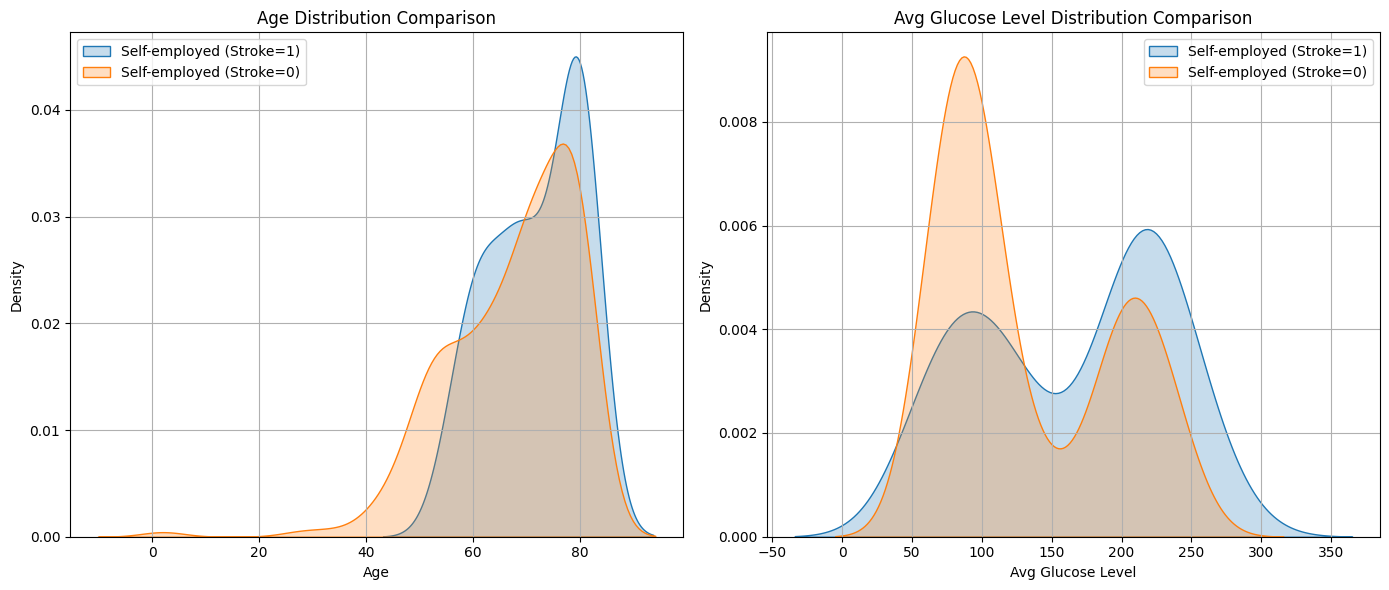

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, feature, title in zip(
    axes,
    ['age', 'avg_glucose_level'],
    ['Age Distribution Comparison', 'Avg Glucose Level Distribution Comparison'],
):
    sns.kdeplot(
        df_ht_stroke[feature], label='Self-employed (Stroke=1)', fill=True, ax=ax
    )
    sns.kdeplot(
        df_ht_no_stroke[feature], label='Self-employed (Stroke=0)', fill=True, ax=ax
    )
    ax.set(title=title, xlabel=feature.replace('_', ' ').title(), ylabel='Density')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [12]:
for feature in ['age', 'avg_glucose_level']:
    u_stat, p_val = mannwhitneyu(
        df_ht_stroke[feature], 
        df_ht_no_stroke[feature], 
        alternative='two-sided'
    )
    print(f"{feature}: u_stat={u_stat:.4f}, p_val={p_val:.4f}")

age: u_stat=6509.5000, p_val=0.0236
avg_glucose_level: u_stat=6928.0000, p_val=0.0019


### Do older age, hypertension, and heart disease together contribute to a higher likelihood of stroke?

In [21]:
# Collapse age groups (optional if needed)
bins = [0, 45, 60, float('inf')]
labels = ['<45', '45–60', '60+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df['age_group'] = df['age_group'].astype('category')

# Combine all three predictors
df['combination'] = df['age_group'].astype(str) + '_' + df['hypertension'].astype(str) + '_' + df['heart_disease'].astype(str)
# Create contingency table of stroke by combo
contingency_table = pd.crosstab(df['combination'], df['stroke'])

contingency_table

stroke,0,1
combination,,
45–60_0_0,965,43
45–60_0_1,44,3
45–60_1_0,127,11
45–60_1_1,7,1
60+_0_0,824,97
60+_0_1,128,31
60+_1_0,200,41
60+_1_1,43,12
<45_0_0,2462,9


In [22]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 = {chi2:.4f}, p-value = {p:.4f}, dof = {dof}")
if p < 0.05:
    print("Reject H0: Significant association found between feature combinations and stroke")
else:
    print("No significant association found")


Chi2 = 362.4036, p-value = 0.0000, dof = 11
Reject H0: Significant association found between feature combinations and stroke


In [25]:
# Calculate stroke rates per group
contingency_table['stroke_rate'] = contingency_table[1] / (contingency_table[0] + contingency_table[1])

# Sort to find high-risk groups
contingency_table_sorted = contingency_table.sort_values(by='stroke_rate', ascending=False)

contingency_table_sorted
## find the confidence interval of the stroke_rate

stroke,0,1,stroke_rate
combination,,,
60+_1_1,43,12,0.218182
60+_0_1,128,31,0.194969
60+_1_0,200,41,0.170124
45–60_1_1,7,1,0.125000
60+_0_0,824,97,0.105320
45–60_1_0,127,11,0.079710
45–60_0_1,44,3,0.063830
45–60_0_0,965,43,0.042659
<45_1_0,54,1,0.018182


<pre>
Insights:
Highest stroke rates (17–22%) occur among older adults (60+) with hypertension and/or heart disease.

Middle age (45–60) groups have moderate stroke rates (4–12%).

Younger people (<45) have very low stroke rates (<2%), even with hypertension or heart disease.

The combination of age + hypertension + heart disease is clearly important for stroke risk.

</pre>

### CI interval of age 

In [30]:
import numpy as np

# Data subset for stroke=1
age_stroke_1 = df.loc[df['stroke'] == 1, 'age'].dropna().values

# Number of bootstrap samples
n_boot = 10000  
medians = []

np.random.seed(42)  # for reproducibility

for _ in range(n_boot):
    sample = np.random.choice(age_stroke_1, size=len(age_stroke_1), replace=True)
    medians.append(np.median(sample))

# Calculate 2.5th and 97.5th percentiles for 95% CI
ci_lower = np.percentile(medians, 2.5)
ci_upper = np.percentile(medians, 97.5)
median_val = np.median(age_stroke_1)

print(f"Median age (stroke=1): {median_val:.2f}")
print(f"95% bootstrap CI for median age (stroke=1): [{ci_lower:.2f}, {ci_upper:.2f}]")


Median age (stroke=1): 71.00
95% bootstrap CI for median age (stroke=1): [69.00, 74.00]


In [37]:
from statsmodels.distributions.empirical_distribution import ECDF

age_stroke_1 = df.loc[df['stroke'] == 1, 'age'].dropna()
ecdf = ECDF(age_stroke_1)

median_val = 60
prob_above_median = 1 - ecdf(median_val)

print(f"Proportion of stroke=1 patients older than median ({median_val}): {prob_above_median:.3f}")


Proportion of stroke=1 patients older than median (60): 0.711


Proportion of stroke=1 patients older than median (71): 0.486


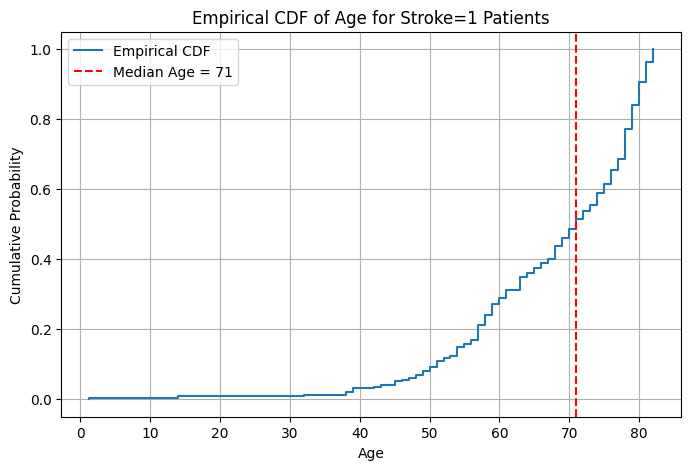

In [35]:
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Filter age data for stroke=1
age_stroke_1 = df.loc[df['stroke'] == 1, 'age'].dropna()

# Compute ECDF
ecdf = ECDF(age_stroke_1)

# Median age
median_val = 71

print(f"Proportion of stroke=1 patients older than median ({median_val}): {prob_above_median:.3f}")

# Plot ECDF
plt.figure(figsize=(8, 5))
plt.step(ecdf.x, ecdf.y, where='post', label='Empirical CDF')
plt.axvline(median_val, color='red', linestyle='--', label=f'Median Age = {median_val}')
plt.xlabel('Age')
plt.ylabel('Cumulative Probability')
plt.title('Empirical CDF of Age for Stroke=1 Patients')
plt.legend()
plt.grid(True)
plt.show()


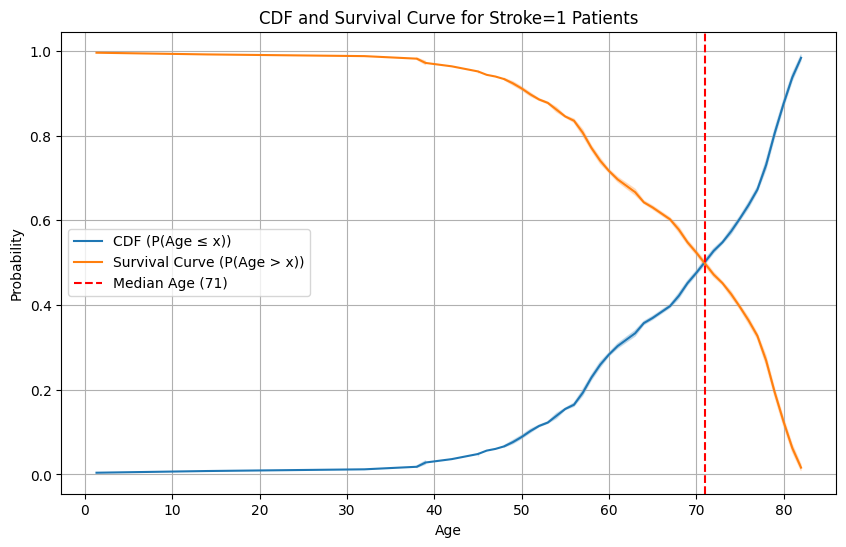

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only stroke=1 cases
stroke_1_ages = df[df['stroke'] == 1]['age'].sort_values()

# Compute CDF
cdf = np.arange(1, len(stroke_1_ages) + 1) / len(stroke_1_ages)

# Plot CDF and Survival Curve
plt.figure(figsize=(10, 6))
sns.lineplot(x=stroke_1_ages, y=cdf, label='CDF (P(Age ≤ x))')
sns.lineplot(x=stroke_1_ages, y=1 - cdf, label='Survival Curve (P(Age > x))')
plt.axvline(71, color='red', linestyle='--', label='Median Age (71)')
plt.xlabel('Age')
plt.ylabel('Probability')
plt.title('CDF and Survival Curve for Stroke=1 Patients')
plt.legend()
plt.grid(True)
plt.show()
